In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal, Optional
from sklearn.manifold import TSNE
from umap import UMAP
import itertools
from pathlib import Path
from loguru import logger
from matplotlib.axes import Axes
from tqdm import tqdm
from tueplots import figsizes, fontsizes, fonts, bundles, axes
import seaborn as sns
from matplotlib.colors import ListedColormap

from histaug.utils import load_features, rc_context, savefig
from histaug.utils.display import RENAME_FEATURE_EXTRACTORS, RENAME_AUGMENTATIONS

figures_dir = Path("/app/figures/visualize_embeddings/kather100k")
figures_dir.mkdir(exist_ok=True, parents=True)

/app/env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was no

In [2]:
# model_a = "ctranspath"
# model_b = "swin"
# model = "resnet50"
# model = "owkin"
# model = "vit"
# model = "retccl"


models = ["dino_p16", "vits"]
augmentations = ["Macenko", "rotate 90°", "rotate random angle"]

N = 10000
# N = 100000
# N = 1000

features_by_model = {
    model: load_features(
        f"/data/histaug/features/kather100k/{model}.zarr",
        remove_classes=["BACK"],
        augmentations=augmentations + ["zoom 1.5x", "rotate random angle and zoom 1.5x"],
        n=N,
    )
    for model in models
}

In [6]:
class LineWidthDataCircle(plt.Circle):
    def __init__(self, *args, **kwargs):
        _lw_data = kwargs.pop("linewidth", 1)
        super().__init__(*args, **kwargs)
        self._lw_data = _lw_data

    def _get_lw(self):
        if self.axes is not None:
            ppd = 72.0 / self.axes.figure.dpi
            trans = self.axes.transData.transform
            return ((trans((1, self._lw_data)) - trans((0, 0))) * ppd)[1]
        else:
            return 1

    def _set_lw(self, lw):
        self._lw_data = lw

    _linewidth = property(_get_lw, _set_lw)


def visualize_embeddings(
    feats: np.ndarray,  # [n_samples, n_features]
    feats_aug: np.ndarray,  # [n_samples, n_features]
    labels: np.ndarray,  # [n_samples] (strings)
    augmentation: str,
    model: str,
    technique: Literal["tsne", "umap", "umap-separate"] = "tsne",
    metric: Literal["euclidean", "cosine", "manhattan"] = "euclidean",
    tsne_perplexity: int = 30,
    umap_n_neighbors: int = 50,
    umap_min_dist: float = 0.1,
    ax: Optional[Axes] = None,
    plot_feats: bool = True,  # plot the features and augmented features
    plot_centroids: bool = True,  # plot the centroids and their spread
    feats_embedded: Optional[
        np.ndarray
    ] = None,  # if None, compute using the specified technique (shape: [n_samples, 2])
    feats_aug_embedded: Optional[
        np.ndarray
    ] = None,  # if None, compute using the specified technique (shape: [n_samples, 2])
    spread_method: Literal["quantile", "std"] = "quantile",
    scatter_size: float = 0.5,
    line_width: float = 0.5,
    line_alpha: float = 0.3,
    classes=None,
    title: bool = True,
):
    classes = sorted(np.unique(labels)) if classes is None else classes
    label2class = {label: i for i, label in enumerate(classes)}

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Generate embeddings using t-SNE
    if feats_embedded is None or feats_aug_embedded is None:
        feats_cat = np.concatenate([feats, feats_aug], axis=0)
        if technique == "tsne":
            feats_embedded = TSNE(
                n_components=2,
                learning_rate="auto",
                init="pca",
                random_state=0,
                perplexity=tsne_perplexity,
                metric=metric,
            ).fit_transform(feats_cat)
            feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)
        elif technique == "umap":
            feats_embedded = UMAP(
                n_components=2, random_state=0, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, metric=metric
            ).fit_transform(feats_cat)
            feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)
        elif technique == "umap-separate":
            umap = UMAP(
                n_components=2, random_state=0, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, metric=metric
            )
            feats_embedded = umap.fit_transform(feats)
            feats_aug_embedded = umap.transform(feats_aug)

    # Use a colormap to map labels to colors
    cmap = matplotlib.colormaps["tab10"]  # 'tab10' is a colormap suitable for categorical data up to 10 categories
    # palette = sns.color_palette("deep", len(classes)).as_hex()
    # palette = sns.color_palette("tab10", len(classes)).as_hex()
    # cmap = ListedColormap(palette)
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(classes) - 1)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)

    if plot_feats:
        if scatter_size:
            # Scatter plots
            ax.scatter(
                feats_embedded[:, 0],
                feats_embedded[:, 1],
                c=[label2class[l] for l in labels],
                s=scatter_size,
                linewidth=0,
                cmap=cmap,
            )

        # Draw lines and annotations
        for f, f_reflect, label in zip(feats_embedded, feats_aug_embedded, labels):
            # ax.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c="k", alpha=0.1)
            ax.plot(
                [f[0], f_reflect[0]],
                [f[1], f_reflect[1]],
                c=sm.to_rgba(label2class[label]),
                alpha=line_alpha,
                linewidth=line_width,
            )

    technique_kwargs = (
        dict(perplexity=tsne_perplexity)
        if technique == "tsne"
        else dict(n_neighbors=umap_n_neighbors, min_dist=umap_min_dist)
    )
    technique_kwargs["metric"] = metric
    technique_kwargs = ", ".join(f"{k}={v}" for k, v in technique_kwargs.items())
    if title:
        ax.set_title(
            f"{'t-SNE' if technique == 'tsne' else 'UMAP'} of {model} features\nfor augmentation {augmentation}\n{technique_kwargs}"
        )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", "box")

    if plot_centroids:
        # Compute centroids for each class
        centroids_per_class = {label: np.mean(feats_embedded[labels == label], axis=0) for label in classes}
        centroids_per_class_aug = {label: np.mean(feats_aug_embedded[labels == label], axis=0) for label in classes}

        # Compute spread for each class (mean distance to centroid)
        dists_to_centroid_per_class = {
            label: np.linalg.norm(feats_embedded[labels == label] - centroids_per_class[label], axis=-1)
            for label in classes
        }
        dists_to_centroid_per_class_aug = {
            label: np.linalg.norm(feats_aug_embedded[labels == label] - centroids_per_class_aug[label], axis=-1)
            for label in classes
        }

        def fat_circle(
            centroids_per_class, dists_to_centroid_per_class, label: str, method: Literal["quantile", "std"]
        ):
            if method == "quantile":
                lower = np.quantile(dists_to_centroid_per_class[label], 0.25)
                upper = np.quantile(dists_to_centroid_per_class[label], 0.75)
            elif method == "std":
                mean = dists_to_centroid_per_class[label].mean()
                lower = mean - dists_to_centroid_per_class[label].std()
                upper = mean + dists_to_centroid_per_class[label].std()
            return LineWidthDataCircle(
                centroids_per_class[label],
                (upper + lower) / 2,
                fill=False,
                color=sm.to_rgba(label2class[label]),
                linewidth=upper - lower,
                alpha=0.3,
            )

        def thin_circle(
            centroids_per_class,
            dists_to_centroid_per_class,
            label: str,
            method: Literal["quantile", "std"],
            **kwargs,
        ):
            return plt.Circle(
                centroids_per_class[label],
                np.quantile(dists_to_centroid_per_class[label], 0.5)
                if method == "quantile"
                else dists_to_centroid_per_class[label].mean(),
                fill=False,
                color=sm.to_rgba(label2class[label]),
                **kwargs,
            )

        # Draw a circle around each centroid with radius equal to the spread
        for label in classes:
            # Draw wider circles to visualize the standard deviation of the spread
            ax.add_artist(fat_circle(centroids_per_class, dists_to_centroid_per_class, label, method=spread_method))
            ax.add_artist(
                fat_circle(centroids_per_class_aug, dists_to_centroid_per_class_aug, label, method=spread_method)
            )
            # Draw the actual circles
            ax.add_artist(thin_circle(centroids_per_class, dists_to_centroid_per_class, label, method=spread_method))
            ax.add_artist(
                thin_circle(
                    centroids_per_class_aug,
                    dists_to_centroid_per_class_aug,
                    label,
                    method=spread_method,
                    linestyle="dotted",
                )
            )

        # Draw a line between each centroid and its augmented counterpart
        for label in classes:
            ax.arrow(
                *centroids_per_class[label],
                *(centroids_per_class_aug[label] - centroids_per_class[label]),
                color=sm.to_rgba(label2class[label]),
                # linestyle="dotted",
                length_includes_head=True,
                head_width=1.0,
            )

        all_feats_embedded = np.concatenate([feats_embedded, feats_aug_embedded], axis=0)
        # plt.xlim(np.min(all_feats_embedded[:, 0]), np.max(all_feats_embedded[:, 0]))
        # plt.ylim(np.min(all_feats_embedded[:, 1]), np.max(all_feats_embedded[:, 1]))

    return feats_embedded, feats_aug_embedded, classes, sm

In [7]:
metric = "cosine"
# metric = "euclidean"
# metric = "manhattan"

technique_kwargs = dict(
    technique="tsne",
    # tsne_perplexity=30,
    tsne_perplexity=30,
)

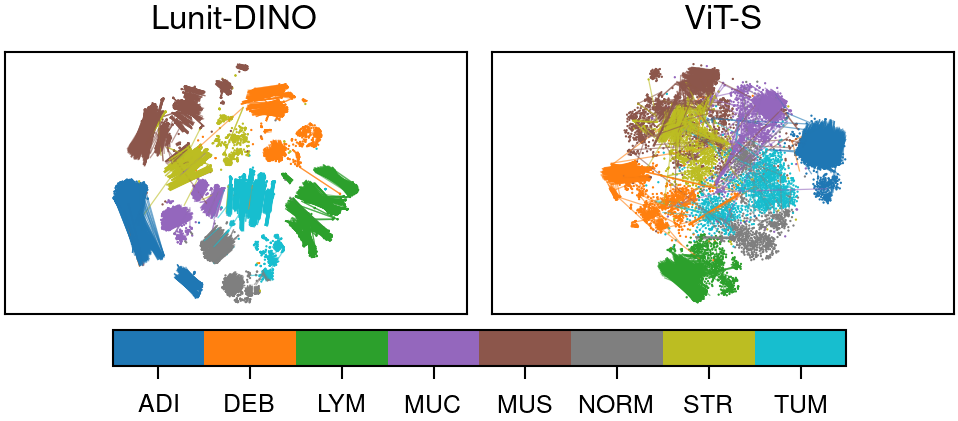

In [8]:
aug_groups = {
    "macenko": ["Macenko"],
    "rotate": ["rotate 90°", "rotate random angle", "rotate random angle ablation"],
}

aug_group = "macenko"
# aug_group = "rotate"
augmentations = aug_groups[aug_group]

with rc_context(
    "half",
    nrows=len(augmentations),
    ncols=len(models),
    height_to_width_ratio=1.0 if len(augmentations) == 1 else 0.6,
    h=0.9 if len(augmentations) == 1 else None,
):
    fig, axs = plt.subplots(nrows=len(augmentations), ncols=len(models))
    if axs.ndim == 1:
        axs = np.expand_dims(axs, axis=0)
    classes = None
    for i_augmentation, (augmentation, row_axs) in enumerate(zip(augmentations, axs)):
        for i_model, (model, ax) in enumerate(zip(models, row_axs)):
            features = features_by_model[model]

            if augmentation != "rotate random angle ablation":
                feats = features.feats
                feats_aug = features.feats_augs[augmentation]
            else:
                feats = features.feats_augs["zoom 1.5x"]
                feats_aug = features.feats_augs["rotate random angle and zoom 1.5x"]
            labels = features.labels

            # feats = feats[:300]
            # feats_aug = feats_aug[:300]
            # labels = labels[:300]
            feats_embedded, feats_aug_embedded, classes, sm = visualize_embeddings(
                feats=feats,
                feats_aug=feats_aug,
                labels=labels,
                augmentation=augmentation,
                metric=metric,
                model=model,
                **technique_kwargs,
                plot_centroids=False,
                plot_feats=True,
                ax=ax,
                scatter_size=0.3,
                line_width=0.3,
                line_alpha=0.6,
                title=False,
                # feats_embedded=feats_embedded,
                # feats_aug_embedded=feats_aug_embedded,
                classes=classes,
            )

            if i_model == 0 and len(augmentations) > 1:
                ax.set_ylabel(
                    RENAME_AUGMENTATIONS.get(augmentation, augmentation)
                    if not augmentation == "rotate random angle ablation"
                    else "ablation"
                )
            if i_augmentation == 0:
                ax.set_title(RENAME_FEATURE_EXTRACTORS[model])
            ax.set_aspect("equal")
            ax.set_adjustable("datalim")

    if len(augmentations) == 1:
        cbar = fig.colorbar(
            mappable=sm,
            boundaries=np.arange(len(classes) + 1) - 0.5,
            orientation="horizontal",
            ax=axs,
            fraction=0.14,
        )
        cbar.set_ticks(range(len(classes)))
        cbar.set_ticklabels(classes)

    savefig(f"visualize_embeddings_{aug_group}")
    plt.show()